In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)     

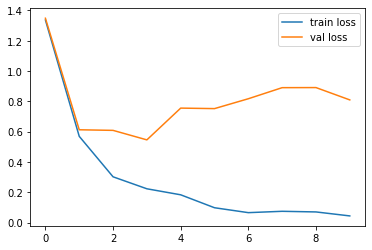

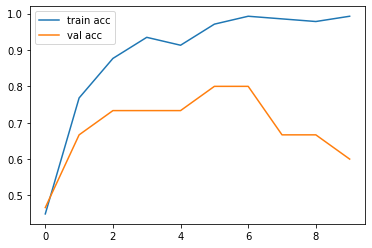

<Figure size 432x288 with 0 Axes>

In [46]:

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'C:\Python37\Projects\Face_Rec_Udemy\25. Face Recognition\Ashish_images\train/'
valid_path = 'C:\Python37\Projects\Face_Rec_Udemy\25. Face Recognition\Ashish_images\validation/'

# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
  

  
  # useful for getting number of classes
#folders = glob('Datasets/Train/*')
folders = glob('C:/Python37/Projects/Face_Rec_Udemy/25. Face Recognition/Ashish_images/train/*')

  

# our layers - you can add more if you want
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(3, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/My Drive/trainingImages/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/images/test/',
                                            target_size = (224, 224),
                                            batch_size = 3,
                                            class_mode = 'categorical')

'''r=model.fit_generator(training_set,
                         samples_per_epoch = 8000,
                         nb_epoch = 5,
                         validation_data = test_set,
                         nb_val_samples = 2000)'''

# fit the modelS
r = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)
# loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# accuracies
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

model.save('facefeatures_new_model.h5')



In [47]:
import cv2
from keras.models import load_model
from keras.preprocessing import image
import numpy as np
from PIL import Image 
model=load_model('facefeatures_new_model.h5')

face_cascade=cv2.CascadeClassifier('haarcascade_frontalface_alt.xml')

def face_extractor(img):
    # function detects faces and return the cropped face
    # If no face detected, it returns the input image
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    faces=face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=5)

    if faces is ():
        return None

    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,255),2)
        cropped_face=img[y:y+h,x:x+w]

    return cropped_face


In [30]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


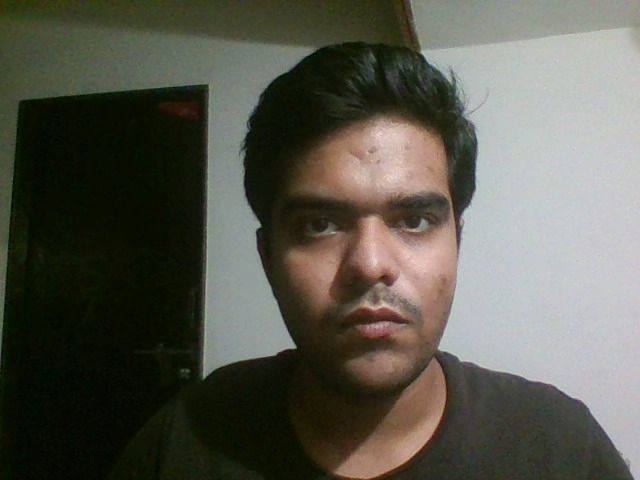

In [16]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [17]:
from google.colab.patches import cv2_imshow

[[6.981712e-08 9.999999e-01 0.000000e+00]]


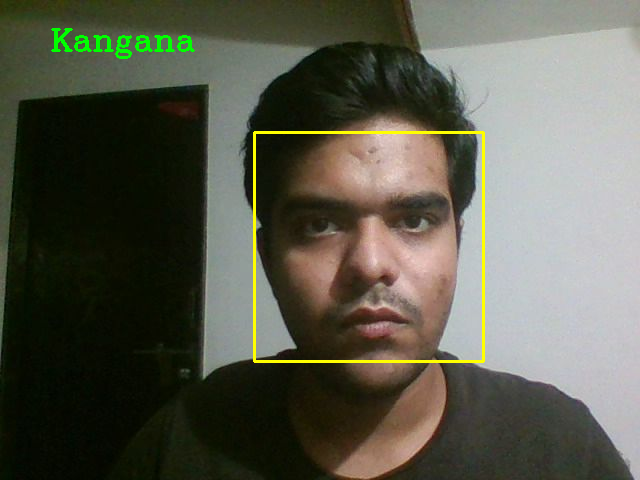

In [48]:
    frame = cv2.imread('photo.jpg')    
    face=face_extractor(frame)
    if type(face) is np.ndarray:
        face=cv2.resize(face,(224,224))
        im= Image.fromarray(face,'RGB')
        img_array=np.array(im)
        img_array=np.expand_dims(img_array,axis=0)
        pred=model.predict(img_array)
        print(pred)

        name={0: 'Priyanka', 1 : 'Kangana', 2 : 'Harsh'}
        
        
        y = np.argmax(pred)
        label = name[y]
        cv2.putText(frame,label,(50,50),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)
    
    else:
          cv2.putText(frame,"No Face Found",(50,50),cv2.FONT_HERSHEY_COMPLEX,1,(0,255,0),2)

    cv2_imshow(frame)
    
      


cv2.destroyAllWindows()

In [38]:
pred

array([[1.00000000e+00, 1.36878274e-17, 0.00000000e+00]], dtype=float32)

In [39]:
y = np.argmax(pred)

In [40]:
y

0